# Default of Credit Card Clients Dataset

This document presents the production of explanations using MeLIME method for a Random Forest (RF) model trained on the Default of Credit Card Clients Dataset (regarding the dataset, please see https://archive-beta.ics.uci.edu/ml/datasets/default+of+credit+card+clients). The produced explanations are compared with LIME methodology.

This notebook compares the LIME with MeLIME results. You will need to have LIME installed with you would like to obtain LIME explanations, you can do that by:
> pip install lime

In [1]:
import sys,os
sys.path.append('../../')

import pickle
import numpy as np
from sklearn import datasets
import sklearn.ensemble
from sklearn import metrics
from matplotlib import pyplot as plt

import lime.lime_tabular
from melime.explainers.explainer import Explainer
from melime.generators.kde_gen import KDEGen
from melime.generators.kdepca_gen import KDEPCAGen
from melime.explainers.visualizations.plot_importance import ExplainGraph
from sklearn import tree

import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
import pandas as pd
np.random.seed(0)

# Data Loading and Preprocessing 

In [2]:
df = pd.read_excel('./default_of_credit_card_clients.xls', skiprows=[0], usecols=lambda x: 'ID' not in x,)

# Sanity checkpoint
print(df.columns)  
print('\n')

# Check columns for out-of-range features (eg. Marital Status: 0)

# Gender (1 = male; 2 = female)
print(df['SEX'].value_counts(dropna=False))
print('\n')

# Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
print(df['EDUCATION'].value_counts(dropna=False))
print('\n')

# Marital status (1 = married; 2 = single; 3 = others)
print(df['MARRIAGE'].value_counts(dropna=False))
print('\n')

# Default status (0 = no; 1 = yes)
print(df['default payment next month'].value_counts(dropna=False))
print('\n')

# # Remove mislabelled rows (may help to ensure better trustworthiness, because label may be more biased toward a mislabelled row)
# print('Number of instance before removing mislabelled rows: ', df.shape[0])

# keep_list = [1, 2, 3, 4]
# df = df[df['EDUCATION'].isin(keep_list)]

# keep_list = [1, 2, 3]
# df = df[df['MARRIAGE'].isin(keep_list)]

print('Number of instance after removing mislabelled rows: ', df.shape[0])

feature_names = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
target_names = ['No', 'Yes']

x_all_df = df.loc[:, df.columns != 'default payment next month']
x_all = x_all_df.to_numpy()
y_all_df = df[['default payment next month']]
y_all = y_all_df.to_numpy()

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')


0    23364
1     6636
Name: default payment next month, dtype: int64


2    18112
1    11888
Name: SEX, dtype: int64


2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64


2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64


0    23364
1     6636
Name: default payment next month, dtype: int64


Number of instance after removing mislabelled rows:  30000


# Data Normalisation

Data does not need to be normalised when using LIME. However, error will occur when using MeLIME due to large feature values in the dataset (eg. 'LIMIT_BAL', 'BILL_AMT1', etc). This results in features like 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', etc to be fractional number, but they maintain their numerical discrete data status.

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
x_all_scaled = min_max_scaler.fit_transform(x_all)

x_train_scaled, x_test_scaled, y_train, y_test = train_test_split(x_all_scaled, y_all, test_size = 0.2, random_state=123)

# Sanity checkpoint
print(x_train_scaled) 
print(np.shape(x_train_scaled))     # should have 29601 * (1 - test_size) rows

[[1.91919192e-01 1.00000000e+00 3.33333333e-01 ... 4.02576490e-03
  6.86940396e-03 2.83733019e-03]
 [1.11111111e-01 1.00000000e+00 1.66666667e-01 ... 1.29146538e-03
  0.00000000e+00 6.16646427e-04]
 [1.01010101e-02 1.00000000e+00 1.66666667e-01 ... 3.22061192e-02
  1.62474298e-03 1.89155346e-03]
 ...
 [4.04040404e-02 1.00000000e+00 5.00000000e-01 ... 1.61030596e-03
  7.66653616e-04 6.22321087e-04]
 [2.02020202e-02 1.00000000e+00 3.33333333e-01 ... 2.84219002e-03
  7.76031641e-04 0.00000000e+00]
 [3.63636364e-01 1.00000000e+00 1.66666667e-01 ... 6.01771337e-03
  5.36891982e-03 4.21040884e-02]]
(24000, 23)


# PCA Analysis

This section use PCA to check the importance of the features without any help from LIME or MeLIME first (just for experimentation). 

In [4]:
model_PCA = PCA(n_components=len(feature_names)).fit(x_train_scaled)
model_PCA.transform(x_train_scaled)

# number of components
n_pcs= model_PCA.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model_PCA.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = feature_names

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

# Check feature importance ranking
df

0          1
0    PC0        SEX
1    PC1      PAY_3
2    PC2   MARRIAGE
3    PC3  LIMIT_BAL
4    PC4   MARRIAGE
5    PC5  EDUCATION
6    PC6      PAY_0
7    PC7  LIMIT_BAL
8    PC8      PAY_0
9    PC9      PAY_2
10  PC10      PAY_3
11  PC11      PAY_5
12  PC12   PAY_AMT5
13  PC13   PAY_AMT6
14  PC14   PAY_AMT5
15  PC15   PAY_AMT4
16  PC16   PAY_AMT1
17  PC17   PAY_AMT3
18  PC18   PAY_AMT2
19  PC19   PAY_AMT2
20  PC20   PAY_AMT1
21  PC21  BILL_AMT5
22  PC22  BILL_AMT3

# Training a RF Model

In [5]:
rf = sklearn.ensemble.RandomForestClassifier(max_depth=6, n_estimators=10)

rf.fit(x_train_scaled, np.ravel(y_train))

y_train_pred = rf.predict(x_train_scaled)
y_test_pred = rf.predict(x_test_scaled)
y_all_pred = rf.predict(x_all_scaled)

In [6]:
print('Acurancy_score: ', metrics.accuracy_score(np.ravel(y_test), y_test_pred))
print('Random Forest Mean Square Error: ', np.mean((y_test_pred - np.ravel(y_test)) ** 2))
print('MSError when predicting the mean: ', np.mean((np.mean(np.ravel(y_train)) - np.ravel(y_test)) ** 2))

Acurancy_score:  0.8206666666666667
Random Forest Mean Square Error:  0.17933333333333334
MSError when predicting the mean:  0.17012291666666665


# Interpretation and Explanation

In [7]:
from melime.explainers.visualizations.visualization import GridPlot

In [16]:
i = 10
x_explain_scaled = x_test_scaled[i]
y_explain = y_test[i][0]

# Sanity Checkpoint
print(x_explain_scaled) 
print(y_explain) 
print(rf.predict(x_explain_scaled.reshape(1, -1)))
print('\n')


i = 13
x_explain_scaled = x_test_scaled[i]
y_explain = y_test[i][0]

# Sanity Checkpoint
print(x_explain_scaled) 
print(y_explain) 
print(rf.predict(x_explain_scaled.reshape(1, -1)))

i = 0
x_explain_scaled = x_test_scaled[i]
y_explain = y_test[i][0]

# Sanity Checkpoint
print(x_explain_scaled) 
print(y_explain) 
print(rf.predict(x_explain_scaled.reshape(1, -1)))

[0.04040404 0.         0.5        0.66666667 0.27586207 0.4
 0.4        0.4        0.5        0.4        0.4        0.1872274
 0.10985301 0.11322187 0.20615475 0.12955018 0.30028119 0.00114475
 0.00239571 0.00111602 0.00225443 0.00656462 0.        ]
1
[1]


[4.04040404e-02 1.00000000e+00 1.66666667e-01 3.33333333e-01
 5.68965517e-01 4.00000000e-01 4.00000000e-01 4.00000000e-01
 2.00000000e-01 2.00000000e-01 2.00000000e-01 1.88929033e-01
 1.14071451e-01 9.60280627e-02 1.76792083e-01 9.85865216e-02
 2.75387757e-01 4.68203381e-03 0.00000000e+00 7.06441677e-04
 1.12077295e-03 2.34450647e-03 1.89155346e-03]
1
[1]


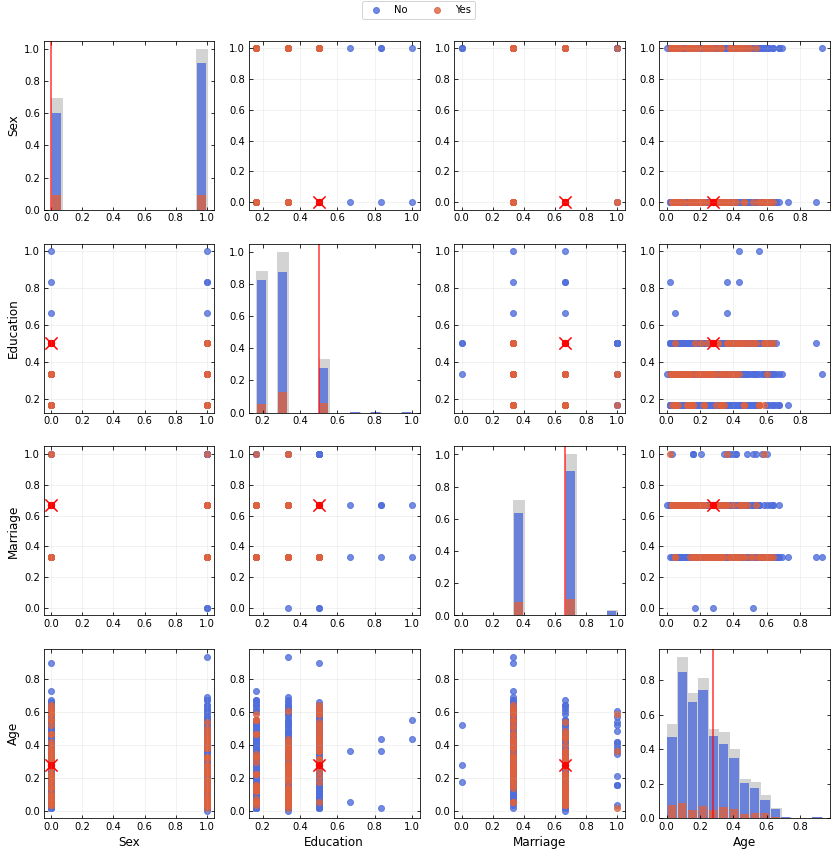

In [17]:
# Code to plot the data and the instance that we want to explain.

# Take only the first 1000 data or else it will be too slow and messy
# 'x_cols_name' should be 'x_all_df.columns' but the number of features is too large at n = 23 (grid will be n x n, or 23 x 23)
# Let the features to be analysed to be 'Sex', 'Education', 'Marriage', 'Age' (X2, X3, X4, and X5 columns)
i = 10
x_explain_scaled = x_test_scaled[i, 1:5]
x = x_all_scaled[:1000, 1:5]
y = y_all_pred[:1000]
y_names = {i:name for i, name in enumerate(target_names)}
colors = ['#4F6DDB', '#DE613E']

axis, _ = GridPlot.plot(
    x=x, x_cols_name=['Sex', 'Education', 'Marriage', 'Age'], y=y, y_names=y_names, colors=colors, alpha=0.8, figsize=(12, 12))
GridPlot.plot_instance(x_explain_scaled, axis)
for ax in axis.ravel():
    start, end = ax.get_xlim()
    stepsize = 0.2
    ax.xaxis.set_ticks(np.arange(int(start), end, stepsize))
    ax.set_xlim([start, end])
plt.savefig('grid_model_predictions.pdf')

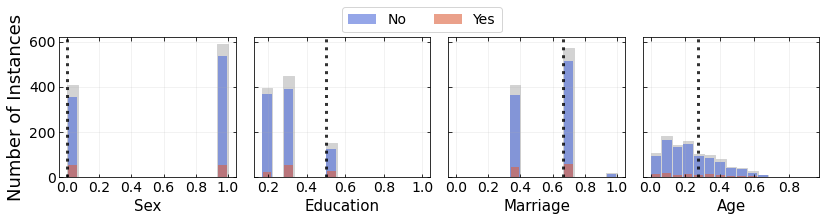

In [18]:
colors = ['#4F6DDB', '#DE613E']
fig, axis = GridPlot.plot_histogram(
    x=x, x_cols_name=['Sex', 'Education', 'Marriage', 'Age'], y=y, y_names=y_names, colors=colors, alpha=0.6, figsize=(12, 3))
for i, ax in enumerate(axis):
    ax.axvline(x_explain_scaled[i], c="black", lw=3.0, linestyle=':', alpha=0.8)   
    start, end = axis[i].get_xlim()
    stepsize = 0.2
    axis[i].xaxis.set_ticks(np.arange(int(start), end, stepsize))
    axis[i].set_xlim([start, end])
axis[0].set_ylabel('Number of Instances', fontsize=18)
plt.savefig('histogram_model_predictions.pdf')

From the above figure, we can see that all four features are not able to separate the default status of individual well. 

We try to plot again using the four top ranking features from the PCA analysis.

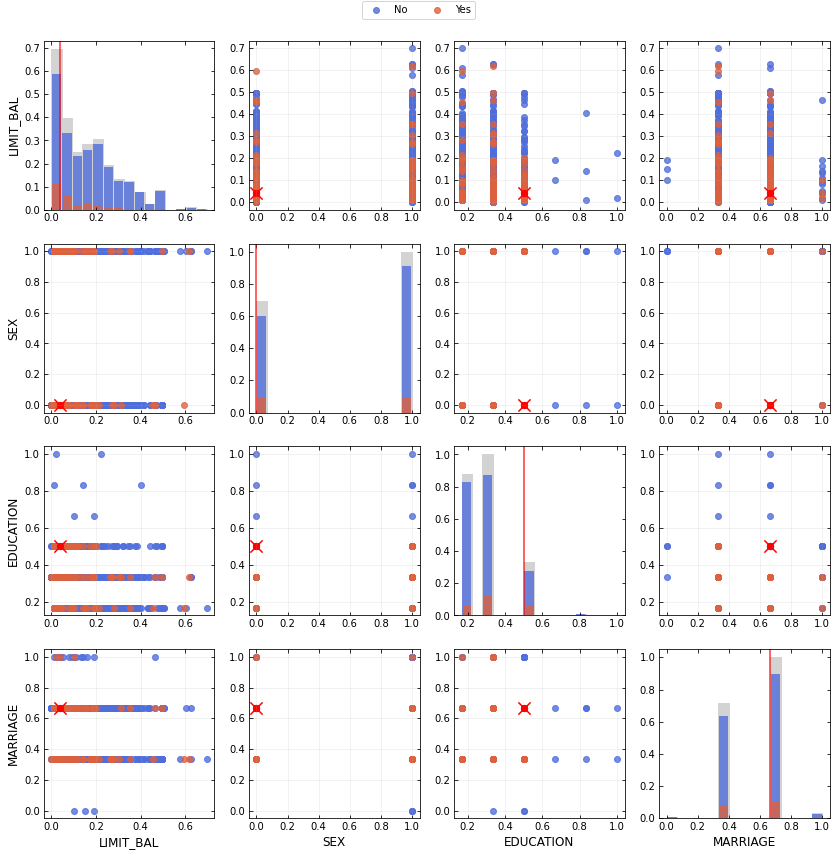

In [19]:
# Code to plot the data and the instance that we want to explain.

# Take only the first 1000 data or else it will be too slow and messy
# 'x_cols_name' should be 'x_all_df.columns' but the number of features is too large at n = 23 (grid will be n x n, or 23 x 23)
# Let the features to be analysed to be 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE' (X1, X2, X3, and X4 columns)
i = 10
x_explain_scaled = x_test_scaled[i, :4]
x = x_all_scaled[:1000, :4]
y = y_all_pred[:1000]
y_names = {i:name for i, name in enumerate(target_names)}
colors = ['#4F6DDB', '#DE613E']

axis, _ = GridPlot.plot(
    x=x, x_cols_name=['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE'], y=y, y_names=y_names, colors=colors, alpha=0.8, figsize=(12, 12))
GridPlot.plot_instance(x_explain_scaled, axis)
for ax in axis.ravel():
    start, end = ax.get_xlim()
    stepsize = 0.2
    ax.xaxis.set_ticks(np.arange(int(start), end, stepsize))
    ax.set_xlim([start, end])
plt.savefig('grid_model_predictions.pdf')

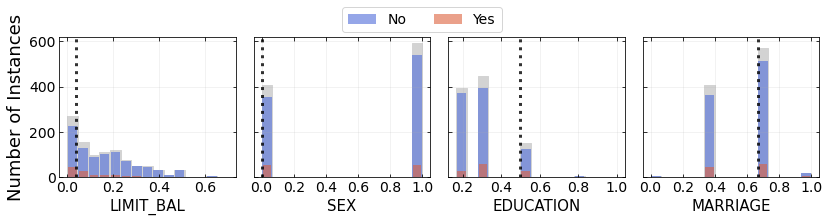

In [20]:
colors = ['#4F6DDB', '#DE613E']
fig, axis = GridPlot.plot_histogram(
    x=x, x_cols_name=['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE'], y=y, y_names=y_names, colors=colors, alpha=0.6, figsize=(12, 3))
for i, ax in enumerate(axis):
    ax.axvline(x_explain_scaled[i], c="black", lw=3.0, linestyle=':', alpha=0.8)   
    start, end = axis[i].get_xlim()
    stepsize = 0.2
    axis[i].xaxis.set_ticks(np.arange(int(start), end, stepsize))
    axis[i].set_xlim([start, end])
axis[0].set_ylabel('Number of Instances', fontsize=18)
plt.savefig('histogram_model_predictions.pdf')

From the above figure, we can see that when **LIMIT_BAL** is low, there is a higher chance of default status.

In [21]:
xgrid = np.linspace(-3.5, 3.5, 40)
ygrid = np.linspace(-6, 6, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)

## Lime Explantion

Let's run the LIME model on two predictions (two default cases and one non-default case). 

For default instance, use data index i = 10 and i = 13.
For non-default instance, use data index i = 0.

In [22]:
categorical_features = []

In [23]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train_scaled,
    feature_names=feature_names,
    class_names=target_names,
    categorical_features=categorical_features,
    verbose=True,
    mode='classification',
    discretize_continuous=False
)

In [24]:
# Trying on first default instance.

i = 10
x_explain_scaled = x_test_scaled[i]

# Sanity checkpoint
print(x_explain_scaled)
print('\n')

exp = explainer.explain_instance(
    x_explain_scaled,
    rf.predict_proba,
    num_features=len(feature_names))

[0.04040404 0.         0.5        0.66666667 0.27586207 0.4
 0.4        0.4        0.5        0.4        0.4        0.1872274
 0.10985301 0.11322187 0.20615475 0.12955018 0.30028119 0.00114475
 0.00239571 0.00111602 0.00225443 0.00656462 0.        ]


Intercept 0.21296679141497998
Prediction_local [0.52143626]
Right: 0.7414122434947917


In [25]:
exp.domain_mapper.feature_values

['0.04',
 '0.00',
 '0.50',
 '0.67',
 '0.28',
 '0.40',
 '0.40',
 '0.40',
 '0.50',
 '0.40',
 '0.40',
 '0.19',
 '0.11',
 '0.11',
 '0.21',
 '0.13',
 '0.30',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.01',
 '0.00']

In [26]:
# Dictionary for plot the explanation
dict_imp = {e[0]:e[1] for e in exp.as_list()}
importances = [dict_imp[e] for e in exp.domain_mapper.feature_names]
explanation = dict(
    chi_names=exp.domain_mapper.feature_names,
    chi_values=np.array(x_explain_scaled).reshape(1,-1),
    x_values=np.array([exp.domain_mapper.feature_values]),
    x_names=exp.domain_mapper.feature_names,
    y_p=rf.predict_proba(x_explain_scaled.reshape(1, -1))[0, 1],
    y_p_max=1.0,
    y_p_min=0.0,
    y_p_local_model=exp.local_pred[0],
    y_p_local_model_max=None,
    y_p_local_model_min=None,
    error=None,
    importances=importances,
    diff_convergence_importances=None,
    ind_class_sorted=0,
    class_names= ["default payment next month"]
)

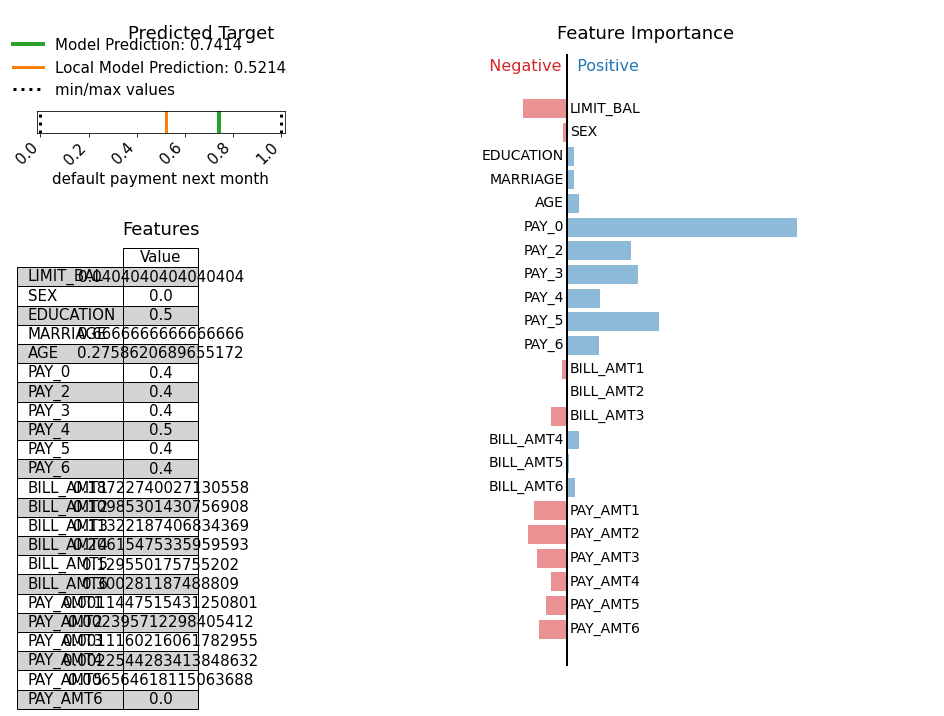

In [27]:
fig, axs = ExplainGraph.plot(explanation)
plt.savefig(f'default_1_credit_card_clients_x_lime.svg', dpi=300)

In [28]:
exp.show_in_notebook(show_table=True)

In [29]:
categorical_features = []

In [30]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train_scaled,
    feature_names=feature_names,
    class_names=target_names,
    categorical_features=categorical_features,
    verbose=True,
    mode='classification',
    discretize_continuous=False
)

In [31]:
# Trying on second default instance.

i = 13
x_explain_scaled = x_test_scaled[i]

# Sanity checkpoint
print(x_explain_scaled)
print('\n')

exp = explainer.explain_instance(
    x_explain_scaled,
    rf.predict_proba,
    num_features=len(feature_names))

[4.04040404e-02 1.00000000e+00 1.66666667e-01 3.33333333e-01
 5.68965517e-01 4.00000000e-01 4.00000000e-01 4.00000000e-01
 2.00000000e-01 2.00000000e-01 2.00000000e-01 1.88929033e-01
 1.14071451e-01 9.60280627e-02 1.76792083e-01 9.85865216e-02
 2.75387757e-01 4.68203381e-03 0.00000000e+00 7.06441677e-04
 1.12077295e-03 2.34450647e-03 1.89155346e-03]


Intercept 0.21409568328711767
Prediction_local [0.4188835]
Right: 0.5582331502452516


In [32]:
exp.domain_mapper.feature_values

['0.04',
 '1.00',
 '0.17',
 '0.33',
 '0.57',
 '0.40',
 '0.40',
 '0.40',
 '0.20',
 '0.20',
 '0.20',
 '0.19',
 '0.11',
 '0.10',
 '0.18',
 '0.10',
 '0.28',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '0.00']

In [33]:
# Dictionary for plot the explanation
dict_imp = {e[0]:e[1] for e in exp.as_list()}
importances = [dict_imp[e] for e in exp.domain_mapper.feature_names]
explanation = dict(
    chi_names=exp.domain_mapper.feature_names,
    chi_values=np.array(x_explain_scaled).reshape(1,-1),
    x_values=np.array([exp.domain_mapper.feature_values]),
    x_names=exp.domain_mapper.feature_names,
    y_p=rf.predict_proba(x_explain_scaled.reshape(1, -1))[0, 1],
    y_p_max=1.0,
    y_p_min=0.0,
    y_p_local_model=exp.local_pred[0],
    y_p_local_model_max=None,
    y_p_local_model_min=None,
    error=None,
    importances=importances,
    diff_convergence_importances=None,
    ind_class_sorted=0,
    class_names= ["default payment next month"]
)

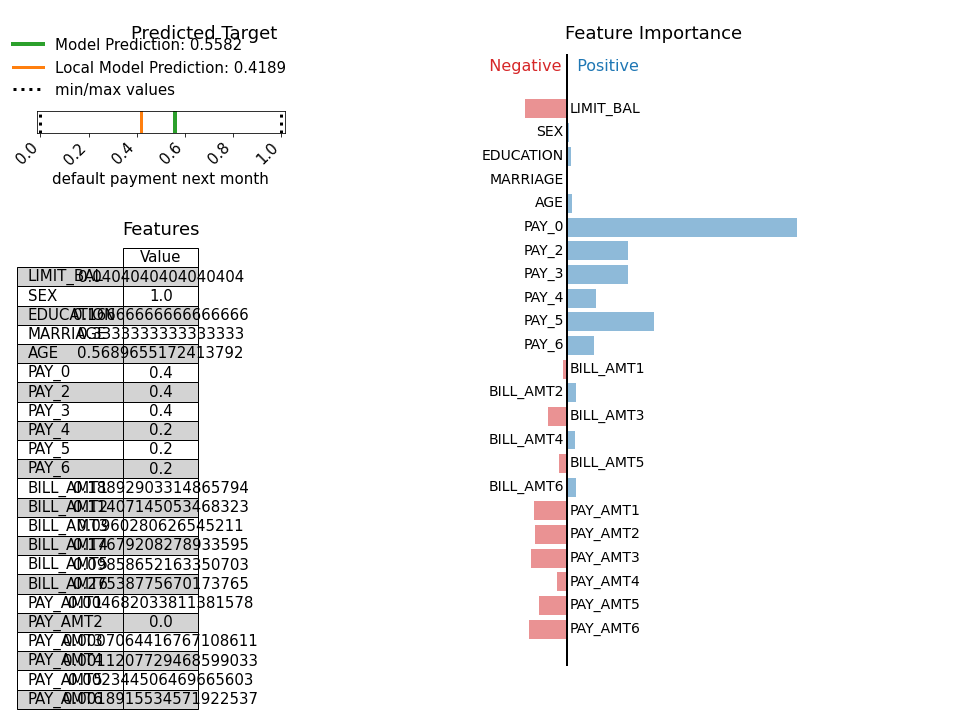

In [34]:
fig, axs = ExplainGraph.plot(explanation)
plt.savefig(f'default_2_credit_card_clients_x_lime.svg', dpi=300)

In [35]:
exp.show_in_notebook(show_table=True)

In [70]:
categorical_features = []

In [71]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train_scaled,
    feature_names=feature_names,
    class_names=target_names,
    categorical_features=categorical_features,
    verbose=True,
    mode='classification',
    discretize_continuous=False
)

In [72]:
# Trying on a non-default instance.

i = 0
x_explain_scaled = x_test_scaled[i]

# Sanity checkpoint
print(x_explain_scaled)
print('\n')

exp = explainer.explain_instance(
    x_explain_scaled,
    rf.predict_proba,
    num_features=len(feature_names))

[3.03030303e-02 1.00000000e+00 3.33333333e-01 6.66666667e-01
 8.62068966e-02 1.00000000e-01 2.00000000e-01 2.00000000e-01
 2.00000000e-01 1.00000000e-01 2.00000000e-01 1.72172860e-01
 8.93682121e-02 9.38115785e-02 1.60137756e-01 1.24300822e-01
 2.75347027e-01 1.48817701e-03 5.93732912e-04 0.00000000e+00
 3.60273752e-02 1.59426440e-03 1.89155346e-02]


Intercept 0.2147027892863656
Prediction_local [0.17728867]
Right: 0.1770530536314555


In [73]:
exp.domain_mapper.feature_values

['0.03',
 '1.00',
 '0.33',
 '0.67',
 '0.09',
 '0.10',
 '0.20',
 '0.20',
 '0.20',
 '0.10',
 '0.20',
 '0.17',
 '0.09',
 '0.09',
 '0.16',
 '0.12',
 '0.28',
 '0.00',
 '0.00',
 '0.00',
 '0.04',
 '0.00',
 '0.02']

In [74]:
# Dictionary for plot the explanation
dict_imp = {e[0]:e[1] for e in exp.as_list()}
importances = [dict_imp[e] for e in exp.domain_mapper.feature_names]
explanation = dict(
    chi_names=exp.domain_mapper.feature_names,
    chi_values=np.array(x_explain_scaled).reshape(1,-1),
    x_values=np.array([exp.domain_mapper.feature_values]),
    x_names=exp.domain_mapper.feature_names,
    y_p=rf.predict_proba(x_explain_scaled.reshape(1, -1))[0, 1],
    y_p_max=1.0,
    y_p_min=0.0,
    y_p_local_model=exp.local_pred[0],
    y_p_local_model_max=None,
    y_p_local_model_min=None,
    error=None,
    importances=importances,
    diff_convergence_importances=None,
    ind_class_sorted=0,
    class_names= ["default payment next month"]
)

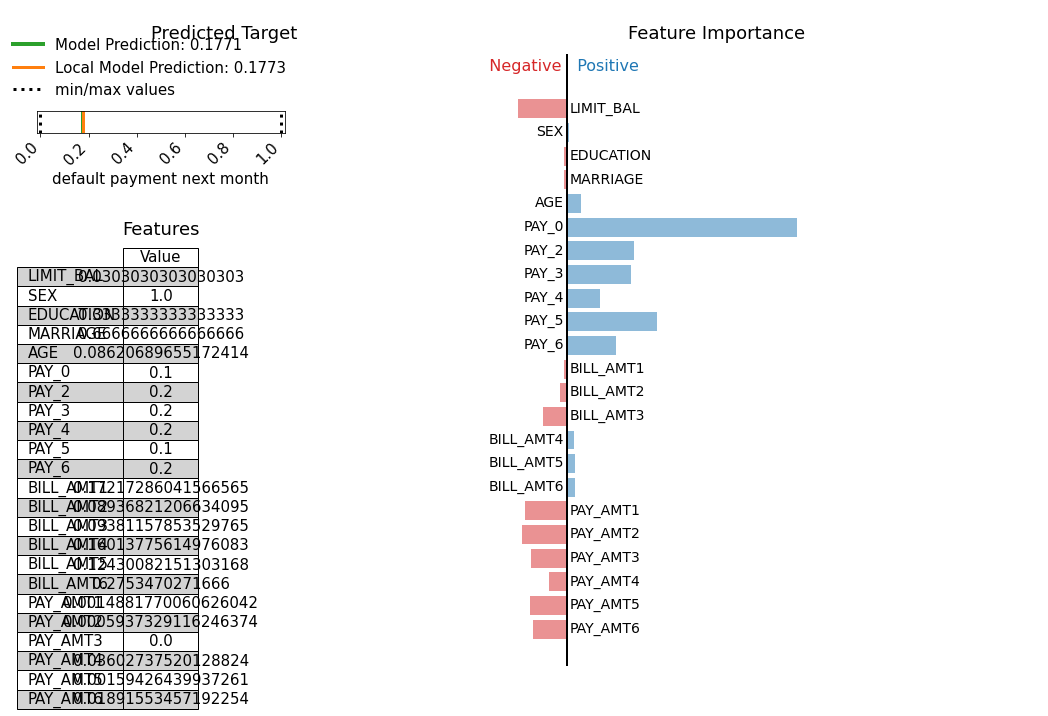

In [75]:
fig, axs = ExplainGraph.plot(explanation)
plt.savefig(f'non_default_1_credit_card_clients_x_lime.svg', dpi=300)

In [76]:
exp.show_in_notebook(show_table=True)

## MeLIME - KDEGen - Explantion

Let's run the MeLIME - KDEGen model on two predictions (two default cases and one non-default case). 

For default instance, use data index i = 10 and i = 13.
For non-default instance, use data index i = 0.

In [36]:
generator = KDEGen(verbose=True).fit(x_train_scaled)

Best Parameter for the KDE:
{'bandwidth': 0.03105263157894737}
Score: 207805.87267040665


In [37]:
# Trying on first default instance.

i = 10
x_explain_scaled = x_test_scaled[i]

explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=feature_names,
    target_names=target_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain_scaled.reshape(1, -1),
    class_index=1,
    r=1.0,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=40,
    scale_data=False,
    weight_kernel='gaussian'
)

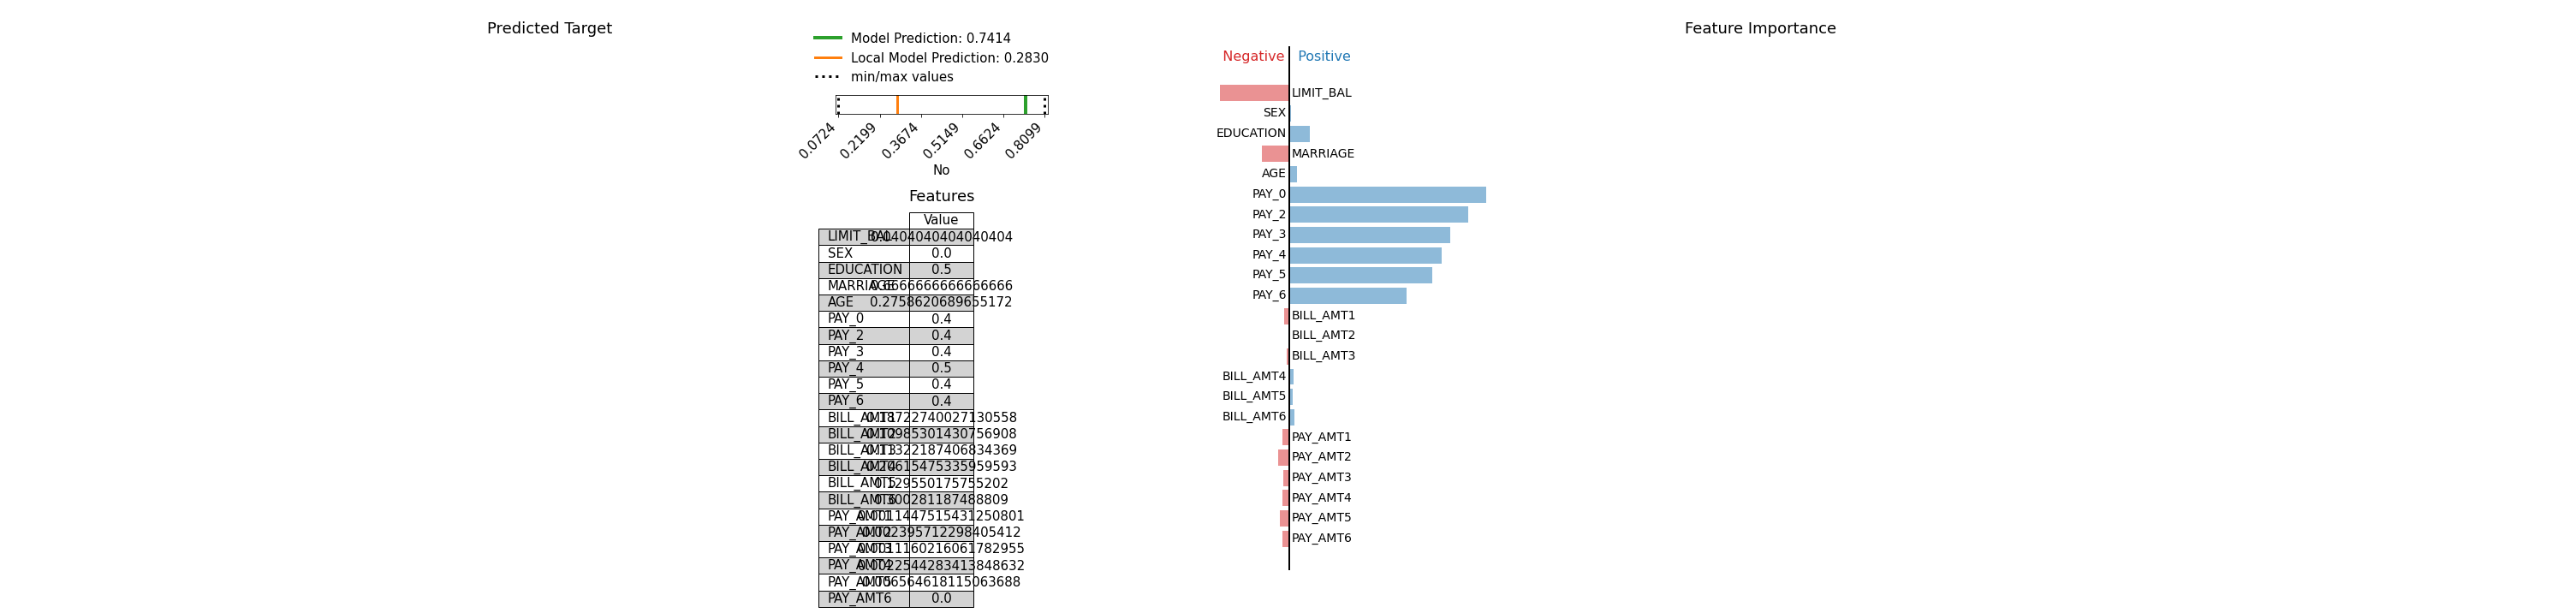

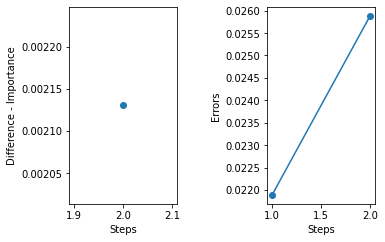

In [38]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'default_1_credit_card_clients_x_m-lime_kde.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

# The image is badly shown in Jupyter Notebook. Please right-click and select 'Open image in new tab'.

In [39]:
# Trying on second default instance.

i = 13
x_explain_scaled = x_test_scaled[i]

explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=feature_names,
    target_names=target_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain_scaled.reshape(1, -1),
    class_index=1,
    r=1.0,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=40,
    scale_data=False,
    weight_kernel='gaussian'
)

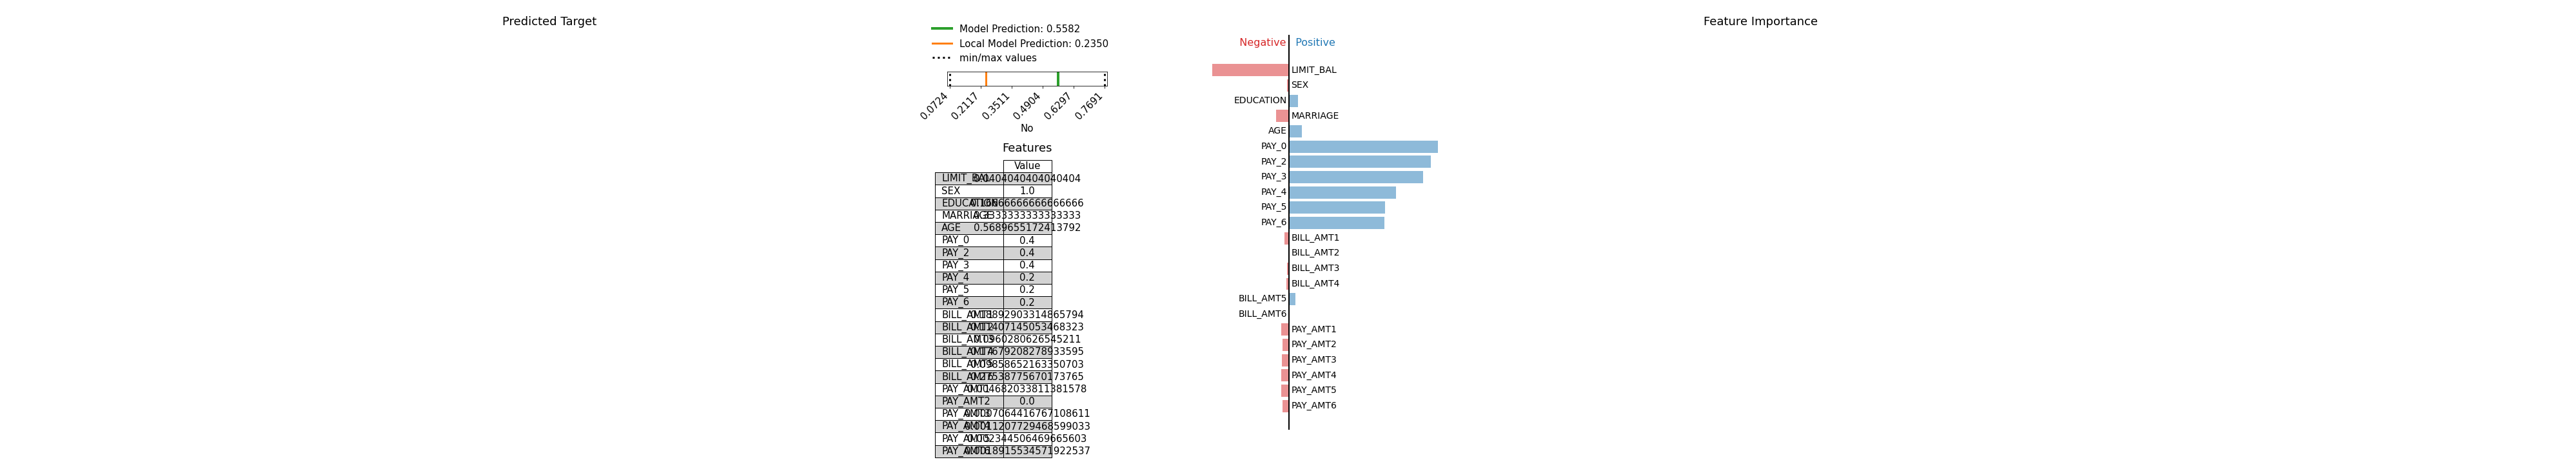

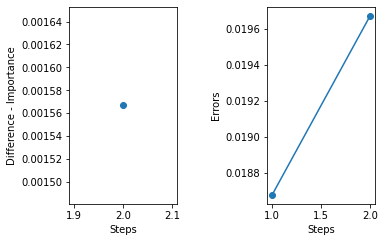

In [40]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'default_2_credit_card_clients_x_m-lime_kde.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

# The image is badly shown in Jupyter Notebook. Please right-click and select 'Open image in new tab'.

In [ ]:
# Trying on a default instance.

i = 0
x_explain_scaled = x_test_scaled[i]

explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=feature_names,
    target_names=target_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain_scaled.reshape(1, -1),
    class_index=1,
    r=1.0,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=40,
    scale_data=False,
    weight_kernel='gaussian'
)

In [ ]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'non_default_1_credit_card_clients_x_m-lime_kde.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

# The image is badly shown in Jupyter Notebook. Please right-click and select 'Open image in new tab'.

## MeLIME - KDEPCAGen - Explantion

Let's run the MeLIME - KDEPCAGen model on two predictions (two default cases and one default case). 

For default instance, use data index i = 10 and i = 13.
For non-default instance, use data index i = 0,

In [41]:
generator = KDEPCAGen(n_components=len(feature_names)).fit(x_train_scaled)

In [42]:
# Trying on first default instance.

i = 10
x_explain_scaled = x_test_scaled[i]

explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=feature_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain_scaled.reshape(1, -1),
    class_index=1,
    r=0.5,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=20,
    scale_data=False,
    weight_kernel='gaussian'
)

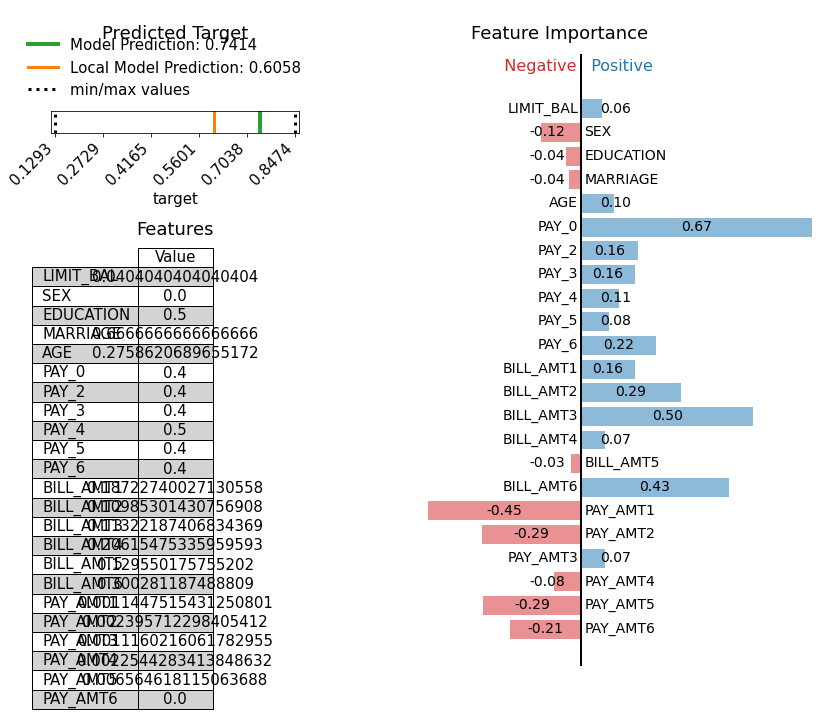

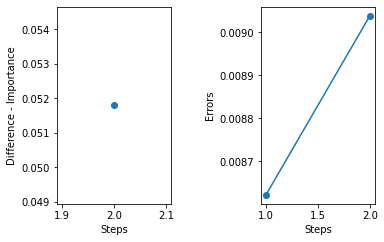

In [43]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'default_1_credit_card_clients_x_m-lime_pcakde.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

In [44]:
# Trying on second default instance.

i = 13
x_explain_scaled = x_test_scaled[i]

explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=feature_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain_scaled.reshape(1, -1),
    class_index=1,
    r=0.5,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=20,
    scale_data=False,
    weight_kernel='gaussian'
)

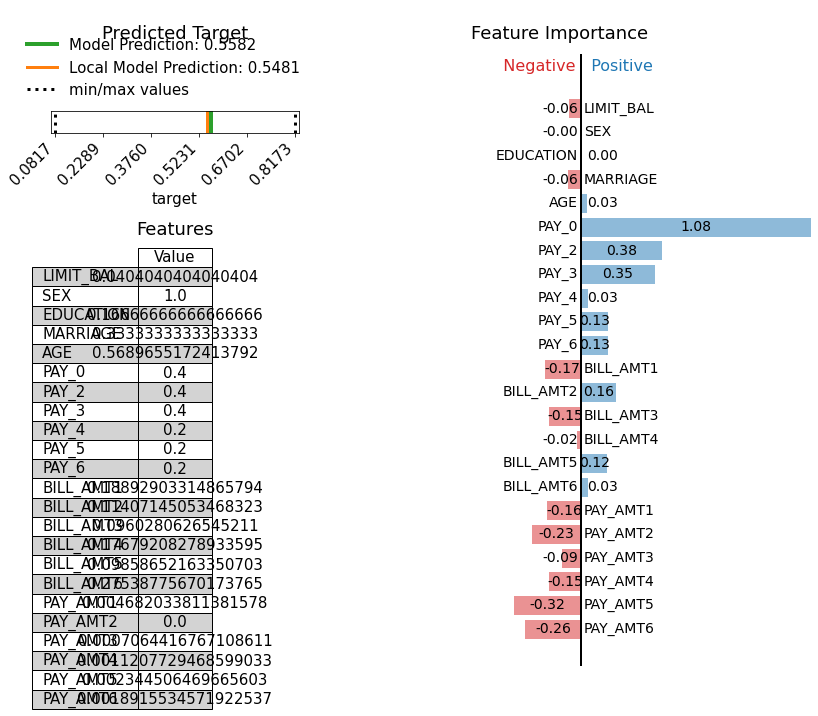

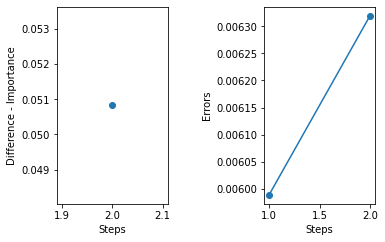

In [45]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'default_2_credit_card_clients_x_m-lime_pcakde.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

In [46]:
# Trying on a default instance.

i = 0
x_explain_scaled = x_test_scaled[i]

explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Ridge', 
    feature_names=feature_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain_scaled.reshape(1, -1),
    class_index=1,
    r=0.5,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=20,
    scale_data=False,
    weight_kernel='gaussian'
)

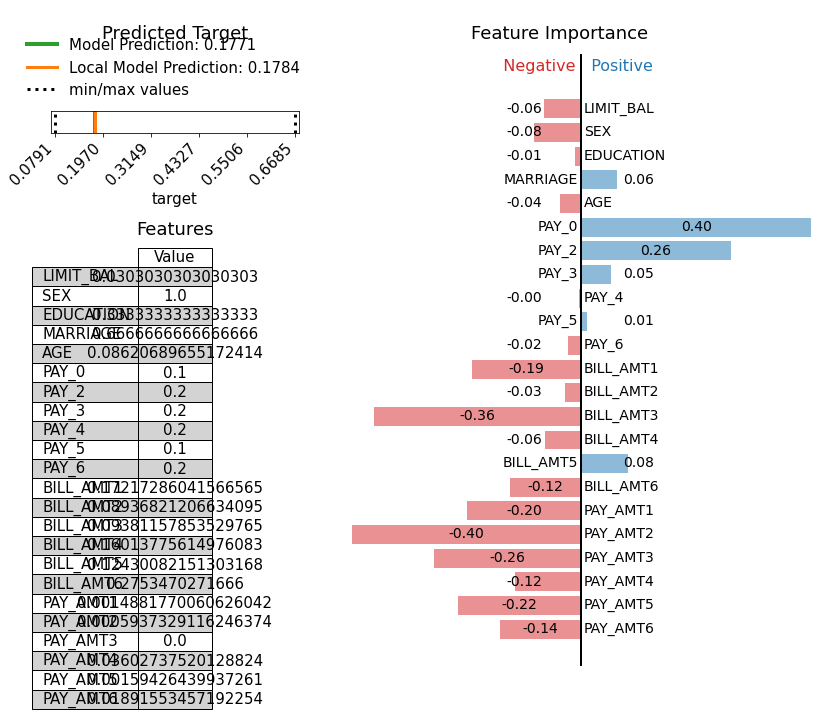

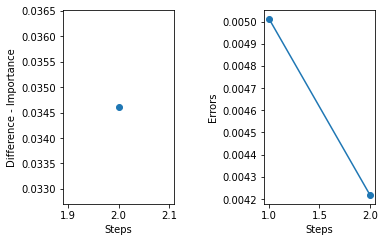

In [47]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'non_default_1_credit_card_clients_x_m-lime_pcakde.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

### Tree Explanation 

Let's run the Tree model on two predictions (two default cases and one non-default case). 

For default instance, use data index i = 10 and i = 13.
For non-default instance, use data index i = 0.

NOTE: Tree local model has an error such that negative importance cannot be plotted. However, it has the best matching prediction when compared to the actual model prediction.

In [61]:
# Trying on first default instance.

i = 10
x_explain_scaled = x_test_scaled[i]

explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Tree', 
    feature_names=feature_names,
    target_names=target_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain_scaled.reshape(1, -1),
    class_index=1,
    r=1.0,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=40,
    scale_data=False,
    weight_kernel='gaussian'
)

../..\melime\explainers\visualizations\plot_importance.py:26: RuntimeWarning: invalid value encountered in double_scalars
  x = x / abs(x) * 0.10


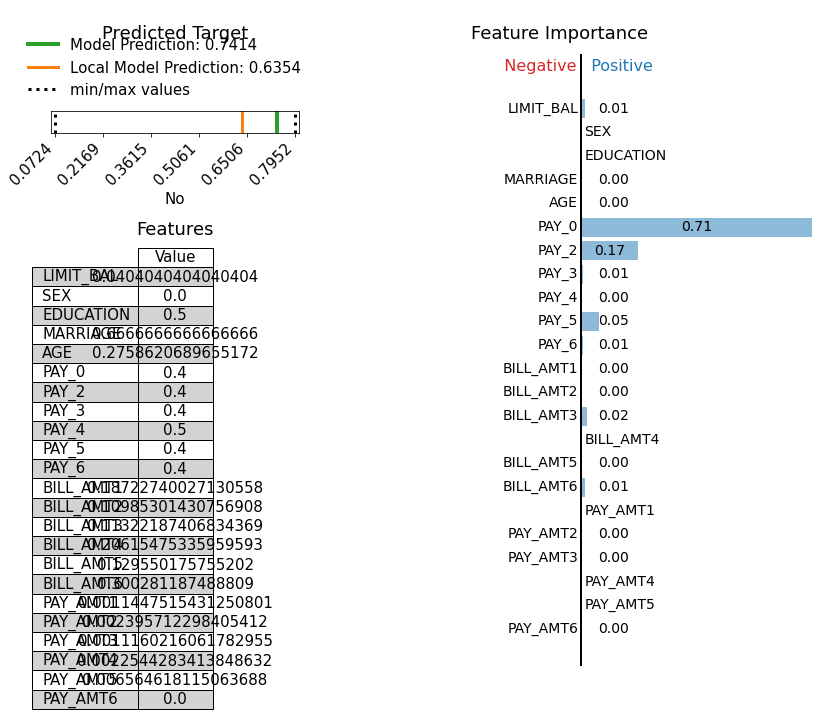

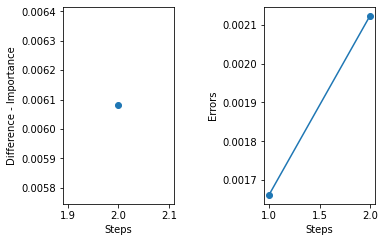

In [62]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'default_1_credit_card_clients_x_m-lime_kdepca_tree.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

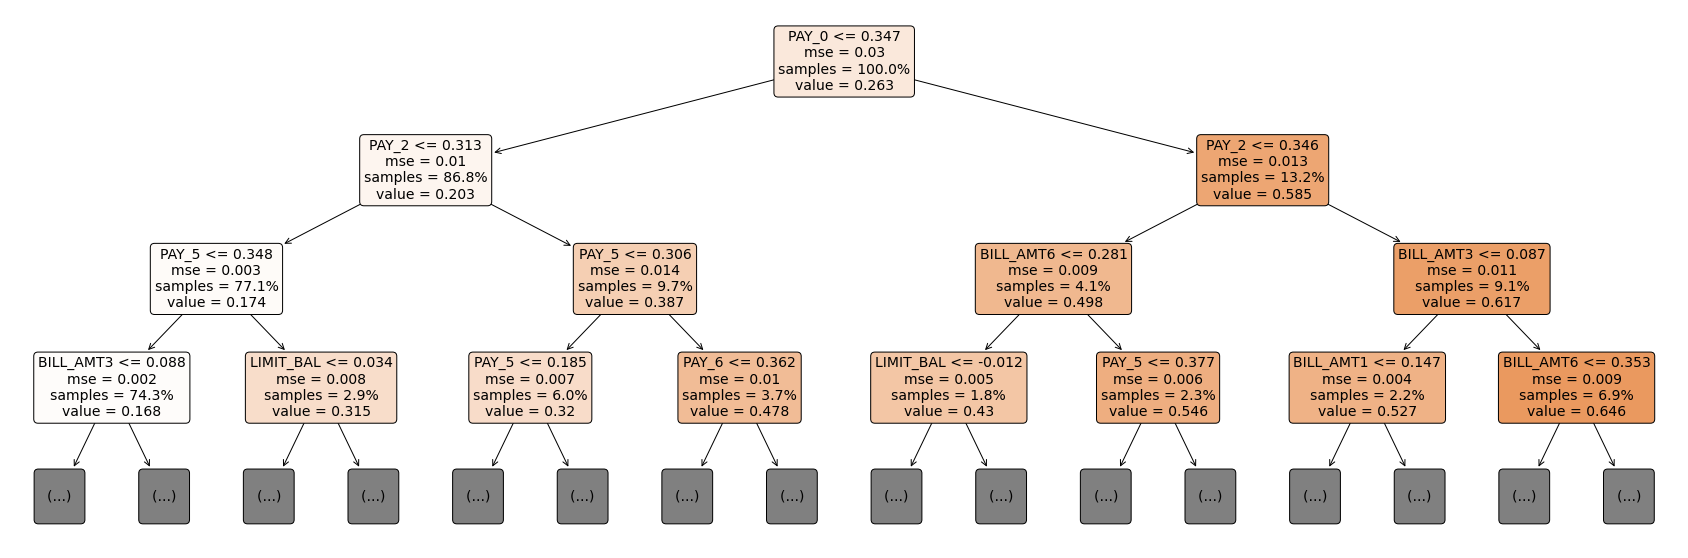

In [63]:
fig = plt.figure(figsize=(30, 10))
explanation.plot_tree()
plt.savefig(f'default_1_credit_card_clients_x_m-lime_kde_tree_plot.svg', dpi=300)

In [64]:
# Trying on second default instance.

i = 13
x_explain_scaled = x_test_scaled[i]

explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Tree', 
    feature_names=feature_names,
    target_names=target_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain_scaled.reshape(1, -1),
    class_index=1,
    r=1.0,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=40,
    scale_data=False,
    weight_kernel='gaussian'
)

../..\melime\explainers\visualizations\plot_importance.py:26: RuntimeWarning: invalid value encountered in double_scalars
  x = x / abs(x) * 0.10


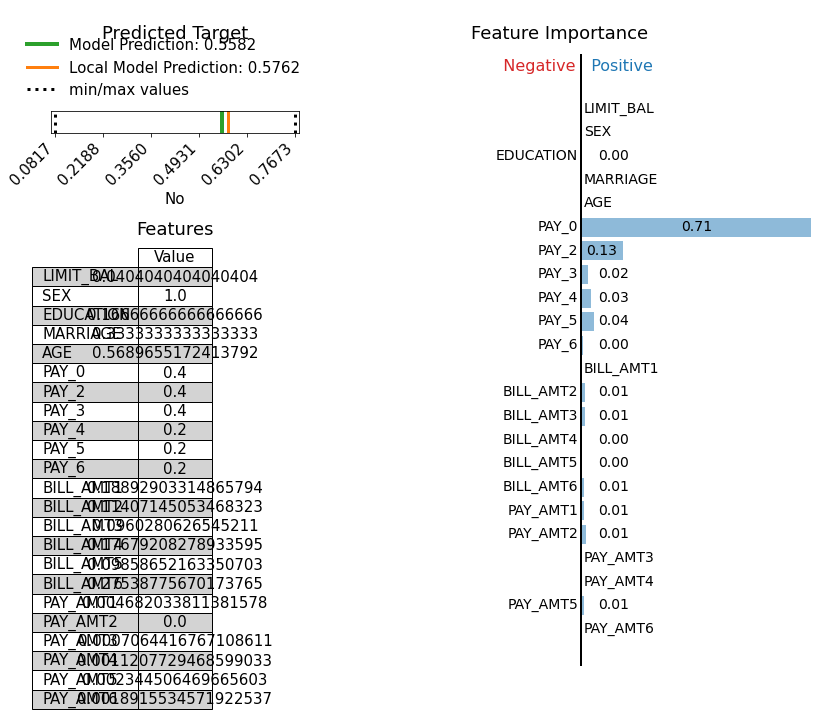

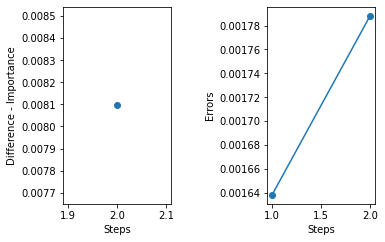

In [65]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'default_2_credit_card_clients_x_m-lime_kdepca_tree.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

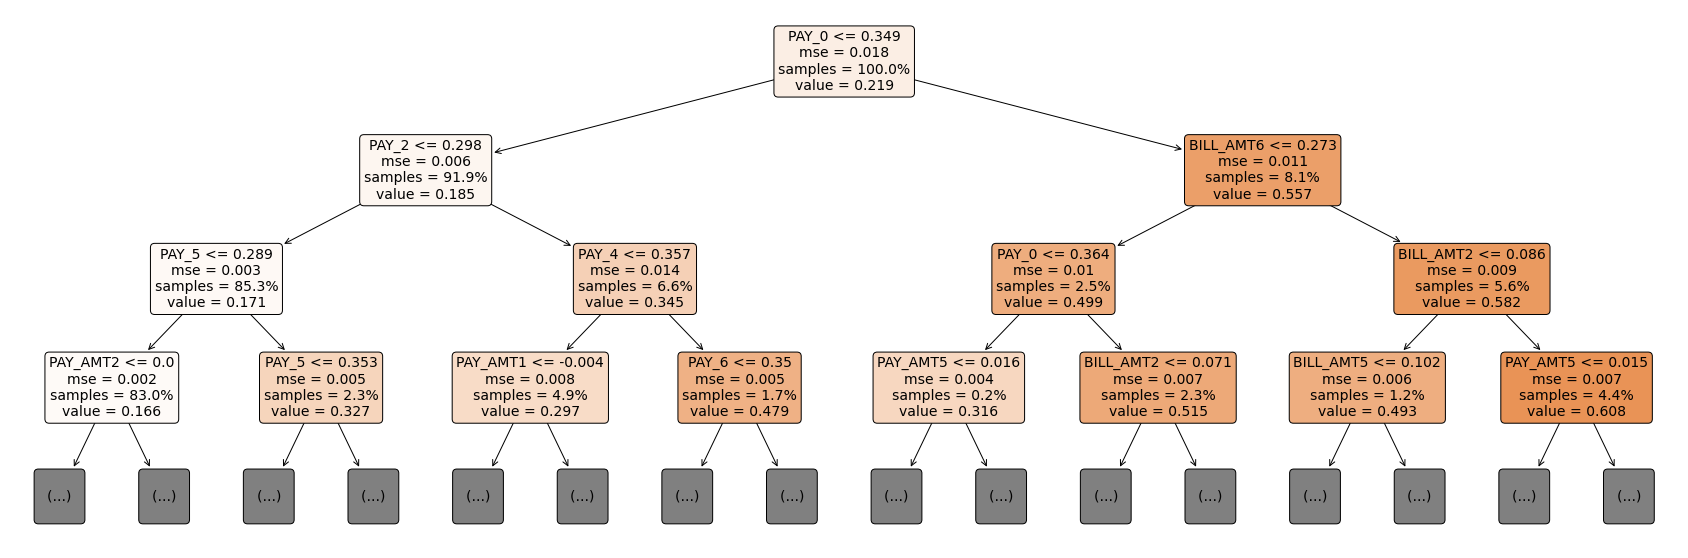

In [66]:
fig = plt.figure(figsize=(30, 10))
explanation.plot_tree()
plt.savefig(f'default_2_credit_card_clients_x_m-lime_kde_tree_plot.svg', dpi=300)

In [67]:
# Trying on a default instance.

i = 0
x_explain_scaled = x_test_scaled[i]

explainer = Explainer(
    model_predict=rf.predict_proba,
    generator=generator, 
    local_model='Tree', 
    feature_names=feature_names,
    target_names=target_names
)
explanation, counterfactual_examples = explainer.explain_instance(
    x_explain=x_explain_scaled.reshape(1, -1),
    class_index=1,
    r=1.0,
    n_samples=500,
    tol_importance=0.1,
    tol_error=0.1,
    local_mini_batch_max=40,
    scale_data=False,
    weight_kernel='gaussian'
)

../..\melime\explainers\visualizations\plot_importance.py:26: RuntimeWarning: invalid value encountered in double_scalars
  x = x / abs(x) * 0.10


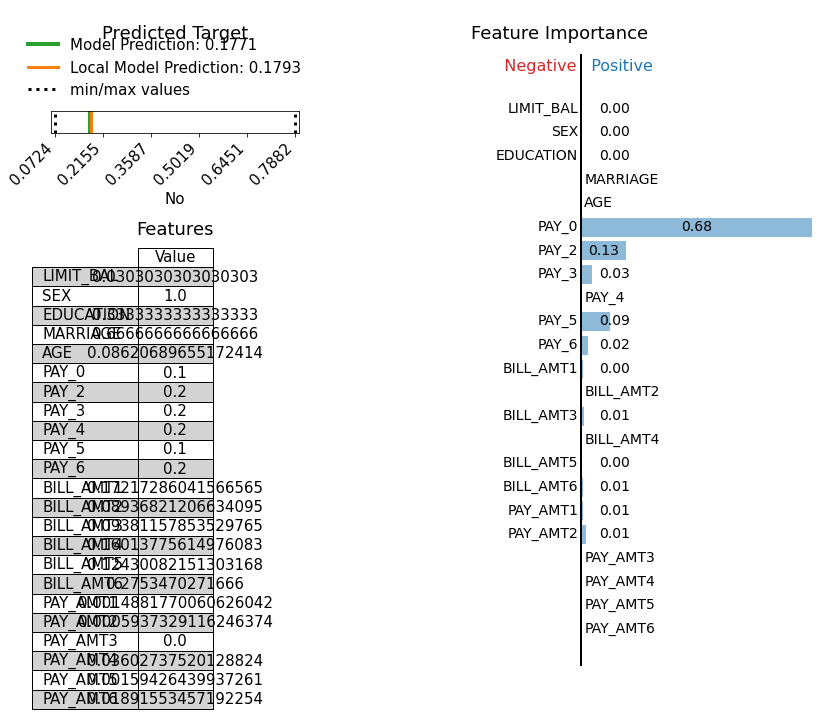

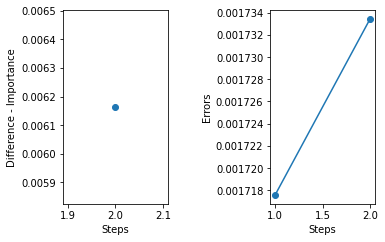

In [68]:
fig, axs = ExplainGraph.plot(explanation.explain())
plt.savefig(f'non_default_1_credit_card_clients_x_m-lime_kdepca_tree.svg')
fig, axs = ExplainGraph.plot_errors(explanation)

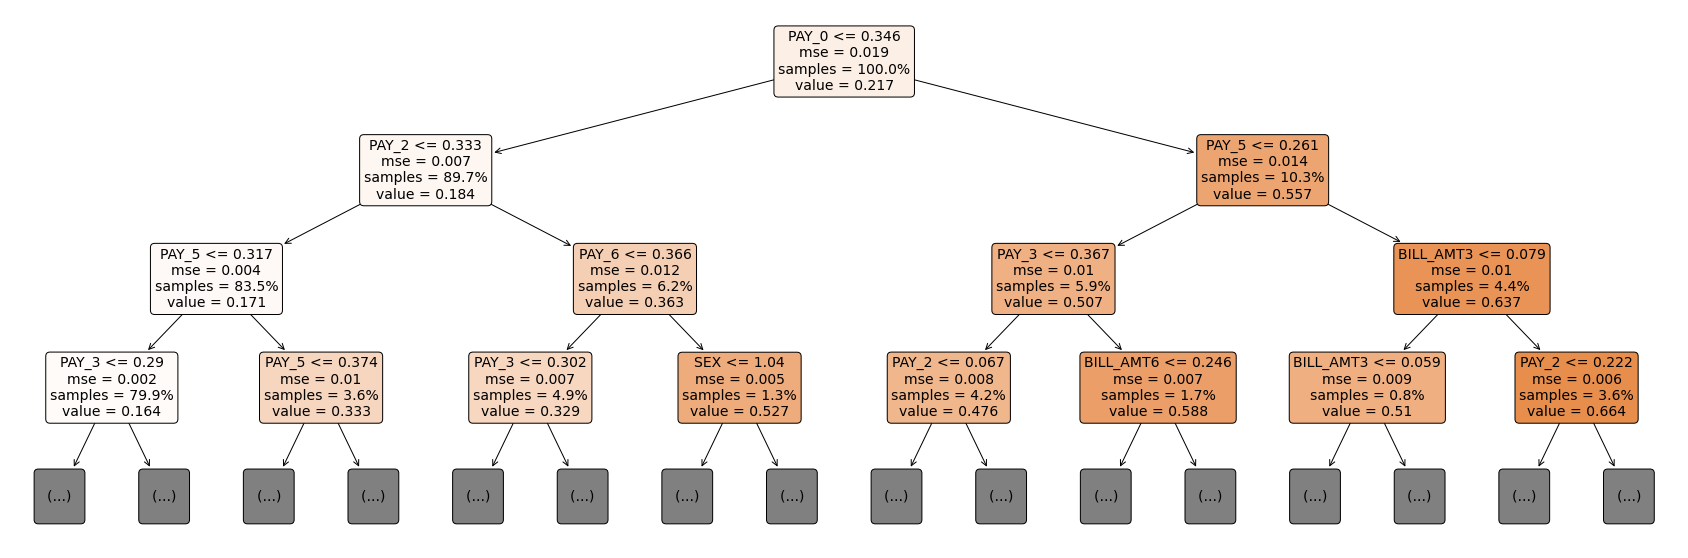

In [69]:
fig = plt.figure(figsize=(30, 10))
explanation.plot_tree()
plt.savefig(f'non_default_1_credit_card_clients_x_m-lime_kde_tree_plot.svg', dpi=300)

# Explaination

**1. What are the top 3 most important features used to predict the default situation? Explain how you arrive at this conclusion.**

When using LIME for explanation, the top 3 most important features are *PAY_0*, *PAY_5*, and *PAY_3* for data index i = 10 and the top 3 most important features are *PAY_0*, *PAY_5*, and *PAY_2* / *PAY_3* for data index i = 13. When *PAY_0*, *PAY_5*, and *PAY_2* / *PAY_3* are high in value, there is a higher chance that the client will default (as shown on the blue side of the plot). Also when *LIMIT_BAL* is low in value, there is a higher chance that the cilent will default (as shown on the red side of the plot).
For data index i = 10, the client delayed the payments by three months for the current month, one month before, two months before, three months before, four months before, and five months before (*PAY_0*, *PAY_2*, *PAY_3*, *PAY_4*, *PAY_5* and *PAY_6* are 3). In addition, the *LIMIT_BAL* of the cilent is \$50,000, which is at the lower end of the range.
For data index i = 13, the client delayed the payments by three months for the current month, one month before, and two months before, and the cilent delayed the payments by one month for three months before, four months before, and five months before (*PAY_0*, *PAY_2*, *PAY_3* are 3 and *PAY_4*, *PAY_5* and *PAY_6* are 1). In addition, the *LIMIT_BAL* of the cilent is $50,000, which is at the lower end of the range.

When using MeLIME - KDEPCAGen (Ridge local model) for explanation, the top 3 most important features are *PAY_0*, *BILL_AMT3*, and *PAY_AMT1* for data index i = 10 and the top 3 most important features are *PAY_0*, *PAY_2*, and *PAY_3* for data index i = 13. When *PAY_0*, *BILL_AMT3*, and *PAY_AMT1* are high in value, there is a higher chance that the client will default (as shown on the blue side of the plot). When *PAY_0*, *PAY_2*, and *PAY_3* are high in value, there is a higher chance that the client will default (as shown on the blue side of the plot).
For data index i = 10, the client delayed the payments by three months for the current month (*PAY_0* is 3).
For data index i = 13, For data index i = 13, the client delayed the payments by three months for the current month, one month before, and two months before, and the cilent delayed the payments by one month for three months before, four months before, and five months before (*PAY_0*, *PAY_2*, *PAY_3* are 3 and *PAY_4*, *PAY_5* and *PAY_6* are 1).

MeLIME - KDEGen is not being used due to large local model prediction mismatch. Although the MeLIME - KDEPCAGen (Tree local model) has excellent local model prediction match, it is not being used as there is error plotting the negative features importance. Thus, the features cannot be ranked in terms of importance visually.

In summary, *PAY_0*, *PAY_2*, and *PAY_3* are the top 3 most important features in general to predict the default prediction.



**2. Study the predictions from your model and identify if any potential features might cause the model to be biased. Explain how you arrive at this conclusion.**

Potential features that might cause the model to be biased:
1. *LIMIT_BAL*

As there are 23364 non-default cases and only 6636 default cases resulting in an imbalanced dataset, the model is more biased towards the non-default class. Thus when an instance has low *LIMIT_BAL*, is may be more easily classified as non-default, regardless of the values of other features.

# Robustness of Explanation (not looking into)

Linear Local Model using KDEPCAGen generator 

Testing over random conditions

In [ ]:
# n_ = 1000
# importances = np.zeros((n_,4))
# for i in range(n_):
#     explainer = Explainer(
#     model_predict=rf.predict_proba,
#     generator=generator, 
#     local_model='Ridge', 
#     feature_names=feature_names
#     )
#     explanation, counterfactual_examples = explainer.explain_instance(
#     x_explain=x_explain.reshape(1, -1),
#     class_index=1,
#     r=0.5,
#     n_samples=500,
#     tol_importance=0.1,
#     tol_error=0.1,
#     local_mini_batch_max=200,
#     scale_data=False,
#     weight_kernel='gaussian'
#     )
#     importances[i] = explanation.importance


In [ ]:
# features_names = explanation.feature_names
# fig, axis = plt.subplots(1,4, figsize=(15, 3))
# for i, name in enumerate(features_names):
#     mean = np.mean(importances[:, i])
#     sigma = np.std(importances[:, i])
#     axis[i].axvline(mean, c="black", linestyle=':', alpha=0.8)
#     values, bins, patches = axis[i].hist(importances[:, i])
#     means_y = np.max(values)/2
#     axis[i].set_title(f'mean: {mean:5.3f}; sigma: {sigma:5.3f}')
#     axis[i].plot(
#         [mean-sigma, sigma+mean], [means_y, means_y], "|", c="black", linestyle='-', alpha=0.5)
#     axis[i].set_xlabel(name, fontsize=14)
#     axis[i].set_xticks(bins[::3])
#     axis[i].tick_params(axis='x', labelsize=14)
#     axis[i].tick_params(axis='y', labelsize=14)
#     for tick in axis[i].get_xticklabels():
#         tick.set_rotation(45)

Testing for small perturabations of $x_{explain}$

In [ ]:
# n_ = 500
# importances = np.zeros((n_,4))
# xs = np.zeros((n_,4))
# for i in range(n_):
#     explainer = Explainer(
#     model_predict=rf.predict_proba,
#     generator=generator, 
#     local_model='Ridge', 
#     feature_names=data.feature_names
#     )
#     error = np.random.rand(4)*0.1
#     x_e = (x_explain[:]+error) 
#     xs[i] = x_e[0]
#     explanation, counterfactual_examples = explainer.explain_instance(
#     x_explain=x_e.reshape(1, -1),
#     class_index=1,
#     r=0.5,
#     n_samples=500,
#     tol_importance=0.1,
#     tol_error=0.1,
#     local_mini_batch_max=200,
#     scale_data=False,
#     weight_kernel='gaussian'
#     )
#     importances[i] = explanation.importance

Plot Features

In [ ]:
# features_names = explanation.feature_names
# fig, axis = plt.subplots(1,4, figsize=(15, 3))
# for i, name in enumerate(features_names):
#     mean = np.mean(importances[:, i])
#     sigma = np.std(importances[:, i])
#     axis[i].axvline(mean, c="black", linestyle=':', alpha=0.8)
#     values, bins, patches = axis[i].hist(importances[:, i])
#     means_y = np.max(values)/2
#     axis[i].set_title(f'mean: {mean:5.3f}; sigma: {sigma:5.3f}')
#     axis[i].plot(
#         [mean-sigma, sigma+mean], [means_y, means_y], "|", c="black", linestyle='-', alpha=0.5)
#     axis[i].set_xlabel(name, fontsize=14)
#     axis[i].tick_params(axis='x', labelsize=14)
#     axis[i].tick_params(axis='y', labelsize=14)
#     for tick in axis[i].get_xticklabels():
#         tick.set_rotation(45)
# #     axis[i].set_xticks(bins[::3])

Plot instances

In [ ]:
# features_names = explanation.feature_names
# fig, axis = plt.subplots(1,4, figsize=(15, 3))
# for i, name in enumerate(features_names):
#     mean = np.mean(xs[:, i])
#     sigma = np.std(xs[:, i])
#     axis[i].axvline(mean, c="black", linestyle=':', alpha=0.8)
#     values, bins, patches = axis[i].hist(xs[:, i])
#     means_y = np.max(values)/2
#     axis[i].set_title(f'mean: {mean:5.3f}; sigma: {sigma:5.3f}')
#     axis[i].plot(
#         [mean-sigma, sigma+mean], [means_y, means_y], "|", c="black", linestyle='-', alpha=0.5)
#     axis[i].set_xlabel(name, fontsize=14)
#     axis[i].tick_params(axis='x', labelsize=14)
#     axis[i].tick_params(axis='y', labelsize=14)
#     for tick in axis[i].get_xticklabels():
#         tick.set_rotation(45)

Thank you!